## Gradient Boosting on RegressionTrees

This solution was not created for the purpose of knocking out the maximum score. It demonstrates how Gradient Descent works on regression trees. Also included in the solution, for cognitive purposes, is the method of principal components and normalization.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,0,40.0,0.0,1400.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,63.0
1,1,48.0,4.0,2850.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,86.0
2,2,39.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
3,3,46.0,5.0,1400.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0
4,4,43.0,1.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0


In [3]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,4999.5000,2886.895680,0.0,2499.75,4999.5,7499.25,9999.0
age,10000.0,45.8780,8.043929,23.0,40.00,46.0,51.00,68.0
years_of_experience,10000.0,1.9868,1.772213,0.0,0.00,2.0,3.00,10.0
lesson_price,10000.0,1699.1050,524.886654,200.0,1300.00,1500.0,2150.00,3950.0
qualification,10000.0,1.7195,0.792264,1.0,1.00,2.0,2.00,4.0
physics,10000.0,0.3750,0.484147,0.0,0.00,0.0,1.00,1.0
chemistry,10000.0,0.1329,0.339484,0.0,0.00,0.0,0.00,1.0
biology,10000.0,0.1096,0.312406,0.0,0.00,0.0,0.00,1.0
english,10000.0,0.0537,0.225436,0.0,0.00,0.0,0.00,1.0
geography,10000.0,0.0321,0.176274,0.0,0.00,0.0,0.00,1.0


Let's look at distributions

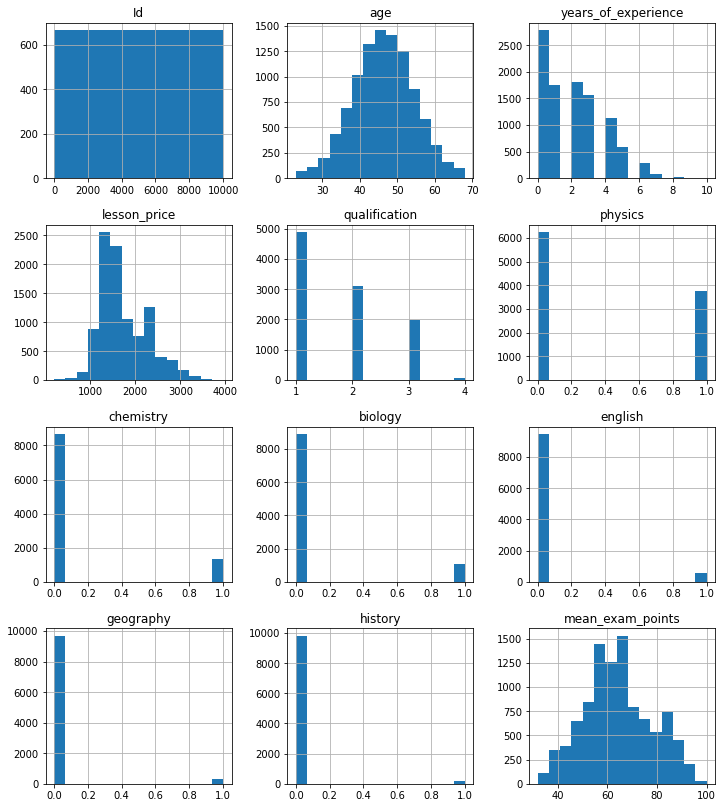

In [4]:
train.hist(figsize =(12,14),bins = 15, grid = True)
plt.show()

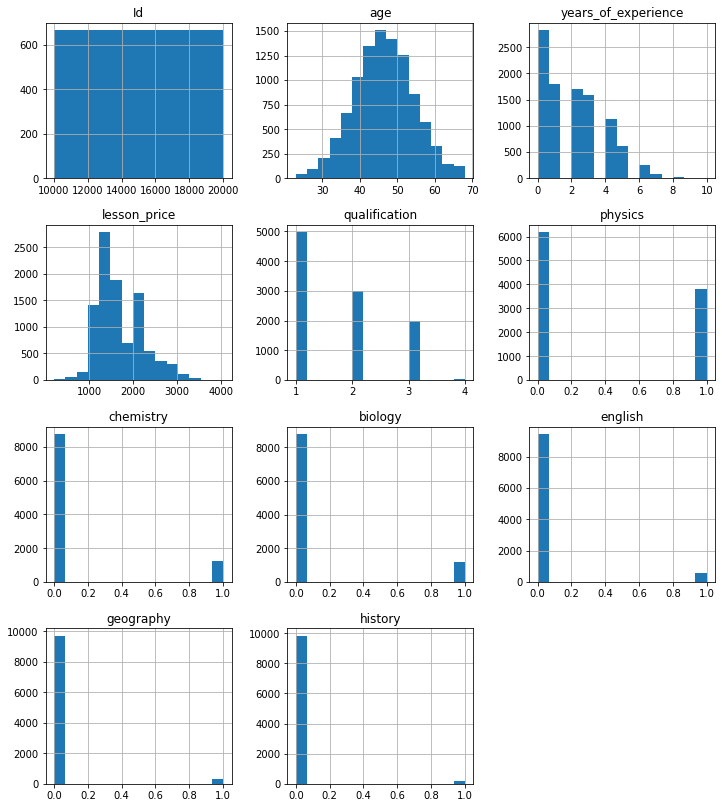

In [5]:
test.hist(figsize =(12,14),bins = 15, grid = True)
plt.show()

Corr matrix

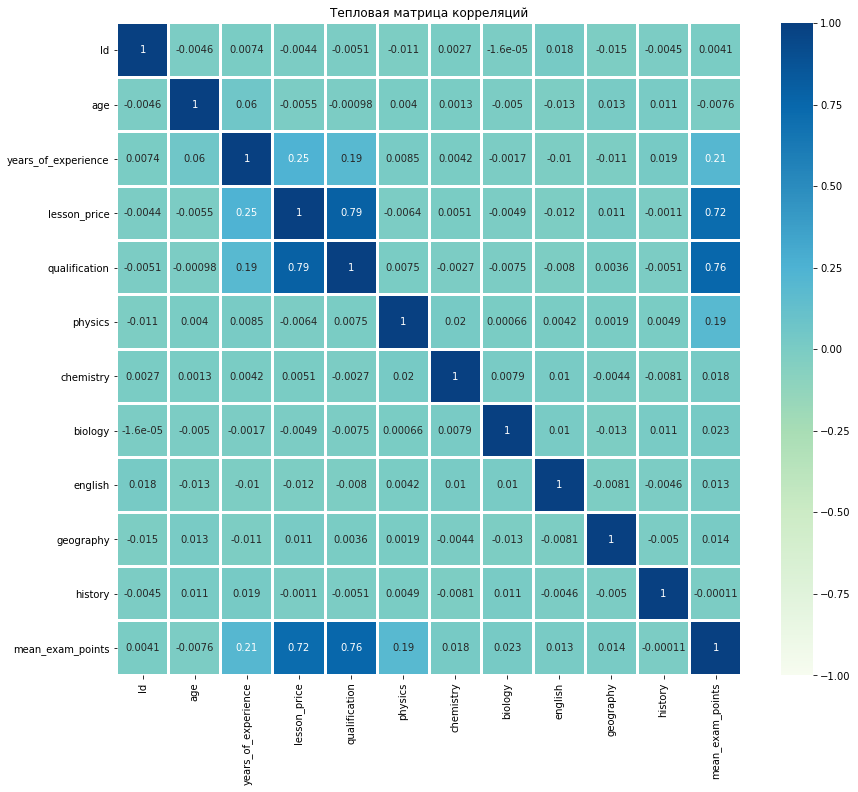

In [6]:
plt.rcParams['figure.figsize'] = (14.0, 12.0)
sns.heatmap(train.corr(), annot = True,fmt='.2g', vmin=-1, vmax=1, center= 0, linewidths = 2, cmap = 'GnBu')
plt.title('Тепловая матрица корреляций')
plt.show()

### Lets make one feature (для приличия выведем один признак)

In [7]:
train['qualification * years_of_experience'] = train['qualification'] * train['years_of_experience']
test['qualification * years_of_experience'] = test['qualification'] * test['years_of_experience']

temp = test.drop(columns='Id')

In [8]:
# Приведем данные к формату array
features = temp.columns
target = 'mean_exam_points'
X = train[features].values
y = train[target].values
test_set = test[features].values

### PCA

In [9]:
class PCA():
    def __init__(self, n_components):
        self.n_components = n_components

    def fit_transform(self, data):
        data_ = data.astype(float)
        cov_matrix = data_.T.dot(data_) # COV matrix
        eig_values, eig_vectors = np.linalg.eig(cov_matrix) # Собственные значения, собственные вектора
        eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:,i]) for i in range(len(eig_values))] # список кортежей (значение, вектор)
        eig_pairs.sort(key=lambda x: x[0], reverse=True) # сортируем список по убыванию eig_values

        eig_sum = sum(eig_values)
        var_exp = [(i / eig_sum) * 100 for i in sorted(eig_values, reverse=True)]
        cum_var_exp = np.cumsum(var_exp)

        w = np.hstack(([eig_pairs[i][1].reshape(data.shape[1], 1) for i in range(self.n_components)]))
        data_pca = data_.dot(w)
        return data_pca, print(f'Доля дисперсии, описываемая каждой компонентой \n{var_exp}'),\
    print(f'Кумулятивная доля дисперсии \n{cum_var_exp}')

In [10]:
imp = ['years_of_experience','lesson_price','qualification']
pca = PCA(n_components=1)
train_components = pca.fit_transform(train[imp])

Доля дисперсии, описываемая каждой компонентой 
[99.99989823183077, 9.405528578671811e-05, 7.71288345065234e-06]
Кумулятивная доля дисперсии 
[ 99.99989823  99.99999229 100.        ]


In [11]:
pca_1 = train_components[0][:].values
pca_1

array([[1399.99937786],
       [2850.0042865 ],
       [1199.99961356],
       ...,
       [1250.00069513],
       [1100.00315289],
       [1449.99931894]])

In [12]:
#X = np.hstack((X,pca_1))

In [13]:
test_components = pca.fit_transform(test[imp])
pca_1 = test_components[0][:].values
pca_1

Доля дисперсии, описываемая каждой компонентой 
[99.99989607297034, 9.645848434026375e-05, 7.468545328482112e-06]
Кумулятивная доля дисперсии 
[ 99.99989607  99.99999253 100.        ]


array([[1050.00320024],
       [1850.00329066],
       [1550.00034805],
       ...,
       [1100.00540977],
       [1750.00000558],
       [2000.00538334]])

In [14]:
#test_set = np.hstack((test_set,pca_1))

### Нормализуем данные ( Standard scaler )

In [15]:
def normalin(data):
    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            data[i][j] = (data[i][j] - means[j])/stds[j]
    return data

In [16]:
#normalin(X)
#normalin(test_set)

### Создадим нашу модель. Попробуем градиентный бустинг на основе регрессора деревьев решений

### Let's try to make gradient boosting based on decision trees regressor

#### RegressionTree

In [17]:
class Node:

    def __init__(self, index, t, true_branch, false_branch):
        # index of the attribute to compare with the threshold in the node / индекс признака для сравнения с порогом в узле
        self.index = index
        # treshold
        self.t = t 
        # branch satisfies condition in node / поддерево, удовлетворяющее условию в узле
        self.true_branch = true_branch 
        self.false_branch = false_branch

class Leaf:

    def __init__(self, data, values):
        self.data = data
        self.values = values
        self.prediction = self.predict()

    def predict(self):

        prediction = np.mean(self.values)
        return prediction

In [18]:
class RegressionTree():

    def __init__(self, max_depth = 50):
        self.max_depth = max_depth
        self.tree = None

    # inform criterion /  критерий информативности
    # In regression, the spread of values will be characterized by variance
    # В случае регрессии разброс значений будет характеризоваться дисперсией
    def inf_criterion(self, values):
        return np.var(values)

    # Quality calculation function / Функция рассчета качества
    def quality(self, left_labels, right_labels, current_dispersion):
        # доля выбоки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
        return current_dispersion - p * self.inf_criterion(left_labels) - (1 - p) * self.inf_criterion(right_labels)

    # Splitting data function / Функция разбиение данных в узле
    def split(self, data, values, index, t):

        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)

        true_data = data[left]
        false_data = data[right]
        true_values = values[left]
        false_values = values[right]

        return true_data, false_data, true_values, false_values

    # Finding the best split / Функция нахождения наилучшего разбиения
    def find_best_split(self, data, values):

        # minimum number of objects in node / обозначим минимальное количество объектов в узле
        min_leaf = 5
        current_inf = self.inf_criterion(values)
        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features):
            # check only unique values / проверяем только уникальные значения признака
            t_values = np.unique([row[index] for row in data])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, values, index, t)
                # If there < 5 objects left in node, we skip node
                #  Если в узле остается < 5 объектов - пропускаем узел
                if len(true_data) < min_leaf or len(false_data) < min_leaf:
                    continue

                current_quality = self.quality(true_labels, false_labels, current_inf)

                # selecting threshold with maximum quality
                #  выбираем порог с максимальным приростом качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index

    # building a tree / Функция построения дерева
    def build_tree(self, data, values, current_deep, max_depth):

        quality, t, index = self.find_best_split(data, values)

        # Stop recursion if there is no quality gain
        # Первый базовый случай (прекращаем рекурсию, если нет прироста качества)
        if quality == 0:
            return Leaf(data, values)
        # Stop recursion if the tree depth is exceeded
        # Второй базовый случай (прекращаем рекурсию, если превышена глубина дерева)
        #(критерий считается достаточно грубым, но хорошо зарекомендовал себя в композициях деревьев)
        if current_deep > max_depth:
            return Leaf(data, values)

        current_deep += 1

        true_data, false_data, true_values, false_values = self.split(data, values, index, t)
        # Building trees / Рекурсивно строим деревья
        true_branch = self.build_tree(true_data, true_values, current_deep, max_depth)
        false_branch = self.build_tree(false_data, false_values, current_deep, max_depth)

        # Возвращаем класс узла всего дерева
        return Node(index, t, true_branch, false_branch)

    # Predicting objects function
    def predict_value(self, obj, node):

        # If have reached the leaf - stop recursion
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.predict_value(obj, node.true_branch)
        else:
            return self.predict_value(obj, node.false_branch)

    def predict(self, data):

        pred_values = []
        for obj in data:
            prediction = self.predict_value(obj, self.tree)
            pred_values.append(prediction)
        return pred_values

    def fit(self, data, values):
        self.tree = self.build_tree(data, values, 0, self.max_depth)

#### Gradient Boosting

In [19]:
class GradBoost:

    def __init__(self, algoritm, max_depth, n_trees, alpha, coef):
        self.max_depth = max_depth
        self.n_trees = n_trees
        self.alpha = alpha
        self.coef = coef
        self.trees = []
        self.train_errors = []
        self.test_errors = []
        self.algoritm = algoritm
    
    def bias(self, y, z):
        return 2*(y - z)

    def fit(self, X_train,X_test, Y_train, Y_test):
        # Cписок деревьев
        trees = []

        for i in range(self.n_trees):
            tree = self.algoritm(max_depth=self.max_depth)
            # инициализируем бустинг начальным алгоритмом, возвращающим ноль,
            # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
            if len(trees) == 0:
                tree.fit(X_train, Y_train)
                
                self.train_errors.append(mean_squared_error(Y_train, self.predict(X_train)))
                self.test_errors.append(mean_squared_error(Y_test, self.predict(X_test)))
            else:
                # Получим ответы на текущей композиции
                values = self.predict(X_train)
                # алгоритмы начиная со второго обучаем на сдвиг
                tree.fit(X_train, self.bias(Y_train, values))
                
                self.train_errors.append(mean_squared_error(Y_train, self.predict(X_train)))
                self.test_errors.append(mean_squared_error(Y_test, self.predict(X_test)))
                
            self.trees.append(tree)
        return self.trees, self.train_errors, self.test_errors

    def predict(self, X):
        return np.array([sum([self.alpha * coef * alg.predict([x])[0] for alg,\
                        coef in zip(self.trees, self.coef)]) for x in X])

In [20]:
def r2_score(y, y_real):
    ss_total=np.sum((y_real-np.mean(y_real))**2)
    ss_res=np.sum((y_real-y)**2)
    return 1-ss_res/ss_total

def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

train_test_split

In [21]:
def tts(X, y, test_size, random_state):
    np.random.seed(random_state)
    
    train_test_cut = int(len(X) * (1 - test_size))
    
    shuffle_index = np.random.permutation(X.shape[0])
    X_shuffled, y_shuffled = X[shuffle_index], y[shuffle_index]
    
    X_train, X_test, y_train, y_test = \
    X_shuffled[:train_test_cut], \
    X_shuffled[train_test_cut:], \
    y_shuffled[:train_test_cut], \
    y_shuffled[train_test_cut:]
    
    return X_train, X_test, y_train, y_test

In [22]:
X_train, X_test, y_train, y_test = tts(X,y,test_size = 0.3, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7000, 11), (3000, 11), (7000,), (3000,))

In [23]:
# lets take coefficients equal to 1
n_trees = 10
coefs = [1] * n_trees

In [24]:
model = GradBoost(algoritm=RegressionTree, max_depth=6, n_trees=n_trees, alpha=0.1, coef = coefs)

In [25]:
# Тут я сразу обучил модель на всей выборке, чтобы потом не обучать еще раз для предикта по тестовой выборке
# По хорошему так делать нельзя! С точки зрения валидации это неправильный подход.

# I immediately trained model on the entire data. But on validations side this is wrong method.
# Don't do that in real tasks.
trees, train_errors, test_errors = model.fit(X,X_test,y, y_test)

In [26]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees):
    train_prediction = model.predict(X_train)

    print(f'Error of algorithm from {n_trees} trees on training set: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = model.predict(X_test)

    print(f'Error of algorithm from {n_trees} trees on test set: {mean_squared_error(y_test, test_prediction)}')

In [27]:
evaluate_alg(X_train, X_test, y_train, y_test, trees)

Error of algorithm from 10 trees on training set: 38.390072535870935
Error of algorithm from 10 trees on test set: 37.96031093366025


In [28]:
y_train_pred = model.predict(X_train)
r2_score(y_train_pred, y_train)

0.7913381350160842

In [29]:
y_test_pred = model.predict(X_test)
r2_score(y_test_pred, y_test)

0.7907560616818643

In [30]:
test_pred = model.predict(test_set)

In [31]:
sub = pd.concat([test['Id'], pd.Series(test_pred)], axis = 1)
sub = sub.rename(columns = {0 : 'mean_exam_points'})

In [32]:
sub

,Id,mean_exam_points
0,10000,55.017523
1,10001,64.041096
2,10002,49.918919
3,10003,90.000000
4,10004,89.618557
...,...,...
9995,19995,40.142857
9996,19996,79.356234
9997,19997,55.017523
9998,19998,64.852713


In [33]:
sub.to_csv('GradBoost_predict.csv', index=None)